# Working with Convolution

In [23]:
import torch
import torch.nn as nn

In [24]:
# Define a single convolution
# kernel_size: the receptive field of the filter 
# stride: controls the stride for the cross-correlation, a single number or a tuple.
# padding: controls the amount of padding applied to the input. It can also
# be a string {'valid', 'same'} 
conv = nn.Conv2d(in_channels=3, 
                 out_channels=32,
                 kernel_size=3,
                 stride=1,
                 padding=0
                )

In [25]:
# Pass some input through the convolutional layer
x = torch.randn(1,3,128,128) # has to have 3 channels because of the in_channels value
y = conv(x)

In [26]:
# What size the output will be?
print(y.size())
# WHY?

torch.Size([1, 32, 126, 126])


To calculate the output of a convolution you can use this simple equation:

$$out\_size = \lfloor(W-K+2P)/S\rfloor+1$$

Where:
- $W$ = input size 
- $K$ = kernel size
- $P$ = padding
- $S$ = stride

In [27]:
# Therefore to mantain the same height and width:
conv = nn.Conv2d(in_channels=3, 
                 out_channels=32,
                 kernel_size=3,
                 stride=1,
                 padding=1 #!!!
                )
y = conv(x)
print(y.size())
# or:
conv = nn.Conv2d(in_channels=3, 
                 out_channels=32,
                 kernel_size=3,
                 stride=1,
                 padding='same' #!!! (only in conv with stride == 1)
                )
y = conv(x)
print(y.size())

torch.Size([1, 32, 128, 128])
torch.Size([1, 32, 128, 128])


In [28]:
# How about reducing the dimension by half?
# Two option: pooling
pool_conv = nn.Sequential(nn.Conv2d(in_channels=3, 
                         out_channels=32,
                         kernel_size=3,
                         stride=1,
                         padding=1),
                         nn.MaxPool2d(kernel_size=2)) # pooling layer: does not have learnable parameters
y = pool_conv(x)
print(y.size())
# or stride
down_conv = nn.Conv2d(in_channels=3, 
                 out_channels=32,
                 kernel_size=3,
                 stride=2, #!!!
                 padding=1 
                )
y = down_conv(x)
print(y.size())

torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])


In [29]:
# How about doubling the output size?
# Two option: upsampling
up_conv = nn.Sequential(nn.Conv2d(in_channels=3, 
                        out_channels=32,
                        kernel_size=3,
                        stride=1,
                        padding=1),
                        nn.Upsample(scale_factor=2)) # upsampling layer: does not have learnable parameters
y = up_conv(x)
print(y.size())
# or transposed convolution
tran_conv = nn.ConvTranspose2d(in_channels=3, # learn the upsampling
                         out_channels=32,
                         kernel_size=4, # !!!
                         stride=2,
                         padding=1
                        )
y = tran_conv(x)
print(y.size())

torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 256, 256])


To calculate output size of transposed convolution the formula becomes:
$$out\_size = (W - 1)S -2P + (K - 1) + 1$$

IMPORTANT: in Generative models it is better to use the manual upsample,
because ConvTranspose2d tends to produce checkboard artifacts!

# Working with image data

In [30]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

from PIL import Image # pip install Pillow

(606, 575)


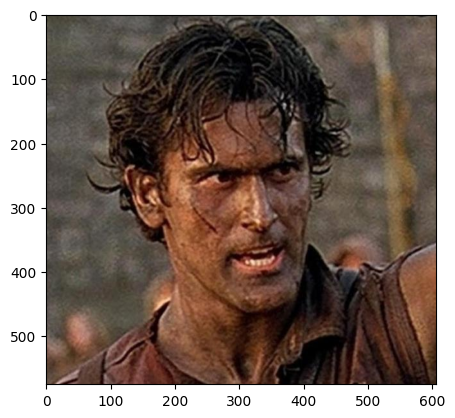

In [31]:
# Load an image
img = Image.open('DeepLearningForEngineeringApplicationsCourse/res/bruce.png')
plt.imshow(img)
print(img.size)

In [32]:
# Convert image to pytorch Tensor and resize it
# Use transforms!
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x[:3])]) # remove the alpha channel if present
img_tensor = transform(img)
print(img_tensor.size())
print(img_tensor.max(), img_tensor.min()) # ToTensor normalizes the image between [0,1]

torch.Size([3, 256, 256])
tensor(0.9882) tensor(0.)


((0, 252), (0, 212), (0, 183))


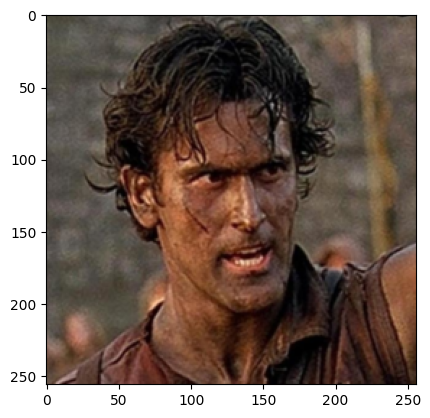

In [33]:
# Back to PIL image
to_pil = transforms.ToPILImage()
img_pil = to_pil(img_tensor) # back to values between [0,255]
print(img_pil.getextrema())
plt.imshow(img_pil)

### Data augmentation and transformation

Often transformations need to be applied to the data in order to be adapted to a particular architecture.
In addition, sometimes it is useful to artificially augment the data in order to increase the size and the diversity of images present in the dataset. 

Common transfomations include:
- Resize
- Normalize
- Random Rotation
- Random Crop
- Center Crop
- Gaussian Blur
- Gray Scale

Usually <code>p</code> stands for the probability to apply a target transformation to an image.

In [ ]:
# Example with random horizontal flip
rhf = transforms.RandomHorizontalFlip(p=0.5)
plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(10,6,i+1)
    plt.imshow(rhf(img_pil))


In [ ]:
# Example with Gaussian Blur
gb = transforms.GaussianBlur(kernel_size=5)
plt.imshow(gb(img_pil))

### Normalization
Often the input of a CNN is normalized between [-1,+1]

$$\hat{x}_c = \frac{x_c - \mu_c}{\sigma_c}$$

Where $\hat{x}$ is the normalize data, $c$ is the channel, $\mu$ is the mean and $\sigma$ is the standard deviation.

In [ ]:
# Normalization example
norm = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
img_tensor_norm = norm(img_tensor)
print(img_tensor_norm.min(), img_tensor_norm.max())

In [ ]:
# If you try to visualize the normalized image it would look bad
plt.imshow(to_pil(img_tensor_norm))

In [ ]:
# Before we need to manually denormalize the image
def denorm(x):
    # Convert the range from [-1, 1] to [0, 1].
    out = (x + 1) / 2
    return out.clamp_(0, 1)

plt.imshow(to_pil(denorm(img_tensor_norm)))

In [ ]:
# Ex1: load an image, resize it to (256,256), the apply the following transformation:
# random crop of (224,224), random horizontal flip with a probability of 85%,
# conversion to tensor and normalization between [-1,1]

torch.Size([3, 224, 224])
tensor(0.9765) tensor(-1.)


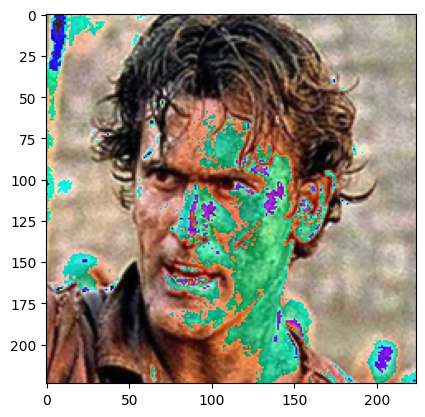

In [34]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(0.85),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3]),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
img_tensor = transform(img)
print(img_tensor.size())
print(img_tensor.max(), img_tensor.min())
plt.imshow(to_pil(img_tensor))

In [ ]:
# Ex2: pass the image through two convolutional layer,
# the first one has to produce an output of size (1,128,112,112),
# the second one has to produce an output of dimension (1,3,224,224)

In [37]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x[:3])]) # remove the alpha channel if present
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)

conv1 = nn.Conv2d(in_channels=3, 
                 out_channels=128,
                 kernel_size=33,
                 stride=2,
                 padding=0
                )
y = conv1(img_tensor)
print(y.shape)

conv2 = nn.ConvTranspose2d(in_channels=128, 
                            out_channels=3,
                            kernel_size=2,
                            stride=2,
                            padding=0
                )
y2 = conv2(y)
print(y2.shape)
plt.imshow(to_pil(y2))

torch.Size([1, 3, 256, 256])
torch.Size([1, 128, 112, 112])
torch.Size([1, 3, 224, 224])


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [ ]:
# Ex3: visualize the output of the last conv layer: how does it look like?

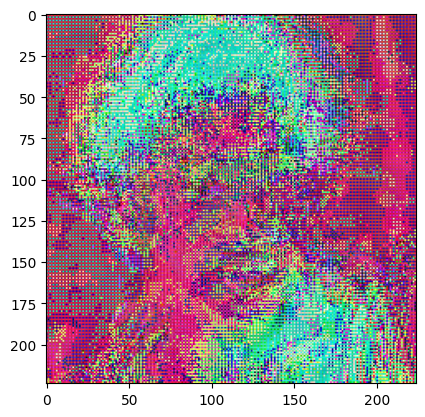

In [36]:
plt.imshow(to_pil(y2.squeeze(0)))